# Background
Variant calling is the process used for identifying variants from sequence data. In order to achieve this one has to align the sequence files (in the FASTQ format) against a genome reference in order to generate a BAM format file. This BAM file can be used with different variant callers in order to identify what positions differ between the sequence data and the genome reference. This process of variant calling is not perfect, and the algorithms used for the analysis can call variants that are spurious and not real, this is why it is advidsable to apply some filters on the variant call set in order to get rid of these fake variants. 

This document describes how to do the variant filtering of a VCF format file generated using BCFTools [[1]](https://samtools.github.io/bcftools/). The approach followed consists on using a supervised machine learning method for the filtering, more specifically we will use a logistic regression classifier and assess the performance on a test dataset in order to decide if the classifier is working

# Data used
In this document we have used a VCF file generated for sample NA12878 using the sequencing data generated for the 1000 Genomes Project. The callset in the VCF file was generated using BCFTools.

# Traning the model
We are going to use the sites in our callset for chr20 that are also found by GIAB NA12878 [[2]](https://github.com/genome-in-a-bottle). GIAB sequenced NA12878 using 13 different sequencing technologies and analysis methods, so the GIAB callset is considered as the gold standard callset and this is why we considered the variants identified by GIAB and us as true sites that are useful to train the model. We will train the classifier independently for the SNPs and the INDELs

## Annotations used for the filtering exercise
BCFTools annotates each of the identified variants with a set of features used as predictors for our model. The variant annotations used are:


BCFTools annotates each site with a different annotation set depending whether the variant is a SNP or an INDEL.   
For SNPs:
DP,RPB,MQB,BQB,MQSB,SGB,MQ0F,ICB,HOB,MQ  
For INDELs:
DP,IDV,IMF,VDB,SGB,MQSB,MQ0F,ICB,HOB,MQ

## SNPs
We are going to use two different SNP VCFs, one has all the sites identified both by GIAB and us (`TP.highconf.vcf.gz`) and the other was identified by us and not by GIAB and are considered False Positive sites (`FP.highconf.vcf.gz`). Only the sites falling in the high-confidence regions as defined by GIAB are considered.
Then we extract the annotations for each of the files by doing:

Now, we read-in the annotations in each of the files into a Pandas dataframe

In [136]:
import pandas as pd
import numpy as np

%matplotlib inline

DF_TP=pd.read_csv('/Users/ernesto/SCRATCH/VARIANT_FILTERING/SNPS/TP_annotations_snps.tsv',sep="\t",na_values=['.'])
DF_FP=pd.read_csv('/Users/ernesto/SCRATCH/VARIANT_FILTERING/SNPS/FP_annotations_snps.tsv',sep="\t",na_values=['.'])

Now we will add a new column named `is_valid` to our two dataframes that will be 1 if the variant is real and will be 0 when the variant is a false positive. This new column will be the dependent binary variable in our classifier

In [137]:
DF_TP=DF_TP.assign(is_valid=1)
DF_FP=DF_FP.assign(is_valid=0)

And now we combine the two dataframes into a single dataframe:

In [138]:
frames = [DF_TP,DF_FP]
DF = pd.concat(frames)

Now, let's identify the columns with NA values:

In [139]:
DF.isna().any()

# [1]CHROM    False
[2]POS        False
[3]DP         False
[4]RPB         True
[5]MQB         True
[6]BQB         True
[7]MQSB       False
[8]SGB        False
[9]MQ0F       False
[10]ICB        True
[11]HOB        True
[12]MQ        False
is_valid      False
dtype: bool

We see several columns with NA values, and the question is how do we deal with them?
Well, there are 2 possibilities, to remove them by using the function `dropna()` or to impute them by using an estimator (mean, median). I will impute the missing values using the median calculated on each feature:

In [185]:
DF_num = DF.drop("# [1]CHROM", axis=1)

In [188]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
imputer.fit(DF_num)
X = imputer.transform(DF_num)

The Numpy array (X) is transformed back to a dataframe:

In [192]:
DF_tr = pd.DataFrame(X, columns=DF.columns.drop(['# [1]CHROM']))

### Normalization of the different features
Some of the machine learning algorithms require that the different predictors are in the same range and are comparable (i.e. having the same units). This is why it is better to do a previous step of data normalization (standardization), for this I am going to use `preprocessing` from `sklearn`

In [193]:
feature_names=DF_tr.columns.drop(['[2]POS','is_valid'])

In [194]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(DF_noNA[feature_names])
std_array = std_scale.transform(DF_noNA[feature_names])

`preprocessing` returns a NumPy array, so we need to transform to a Pandas data frame:

In [195]:
aDF_std=pd.DataFrame(data=std_array,columns=feature_names)

Now, let's add the column with the status of the variant( is_valid=0 or is_valid=1) to the normalized data frame

In [196]:
aDF_std.insert(loc=0, column='is_valid', value=DF_noNA['is_valid'].values)

### Initial exploration of the data
First, let's examine the number of records having `is_valid=1` (i.e. True positive) and `is_valid=0` (i.e. False Positive) 

In [197]:
aDF_std.iloc[:,0].value_counts()

1    2704408
0      44348
Name: is_valid, dtype: int64

Let's examine the distribution of the different predictors depending on the `is_valid` variable.

#### DP (Raw read depth)

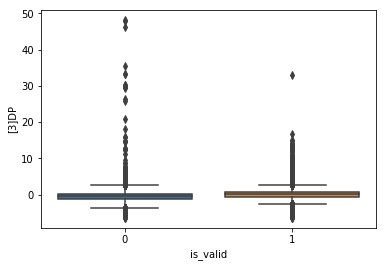

In [198]:
import seaborn as sns
ax = sns.boxplot(x="is_valid", y="[3]DP", data=aDF_std)

* Mean for each category

In [199]:
aDF_std.groupby("is_valid").agg({'[3]DP': 'mean'})

,[3]DP
is_valid,
0,-0.498396
1,0.008173


* Median for each category

In [200]:
aDF_std.groupby("is_valid").agg({'[3]DP': 'median'})

,[3]DP
is_valid,
0,-0.350908
1,0.104439


Judging by the above boxplots and by the median and mean above, we can see that DP is bigger in real sites but that the false positive set present a higher number of DP outliers

#### RPB (Mann-Whitney U test of Read Position Bias (bigger is better))

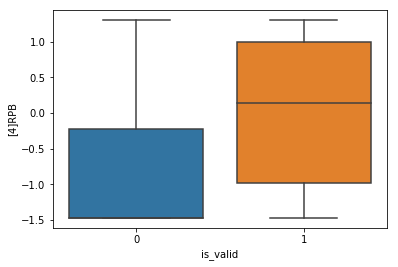

In [201]:
ax = sns.boxplot(x="is_valid", y="[4]RPB", data=aDF_std)

* Mean for each category

In [202]:
aDF_std.groupby("is_valid").agg({'[4]RPB': 'mean'})

,[4]RPB
is_valid,
0,-0.825479
1,0.013537


* Median for each category

In [203]:
aDF_std.groupby("is_valid").agg({'[4]RPB': 'median'})

,[4]RPB
is_valid,
0,-1.472132
1,0.143161


#### MQB (Mann-Whitney U test of Mapping Quality Bias (bigger is better))

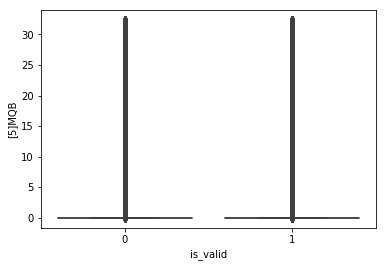

In [204]:
ax = sns.boxplot(x="is_valid", y="[5]MQB", data=aDF_std)

* Mean for each category

In [205]:
aDF_std.groupby("is_valid").agg({'[5]MQB': 'mean'})

,[5]MQB
is_valid,
0,0.261703
1,-0.004292


* Median for each category

In [206]:
aDF_std.groupby("is_valid").agg({'[5]MQB': 'median'})

,[5]MQB
is_valid,
0,-0.045766
1,-0.045766


#### BQB (Mann-Whitney U test of Base Quality Bias (bigger is better))

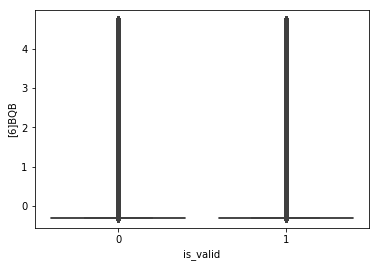

In [207]:
ax = sns.boxplot(x="is_valid", y="[6]BQB", data=aDF_std)

* Mean for each category

In [208]:
aDF_std.groupby("is_valid").agg({'[6]BQB': 'mean'})

,[6]BQB
is_valid,
0,-0.159657
1,0.002618


* Median for each category

In [209]:
aDF_std.groupby("is_valid").agg({'[6]BQB': 'median'})

,[6]BQB
is_valid,
0,-0.305792
1,-0.305792


#### MQSB-Mann-Whitney U test of Mapping Quality vs Strand Bias (bigger is better)

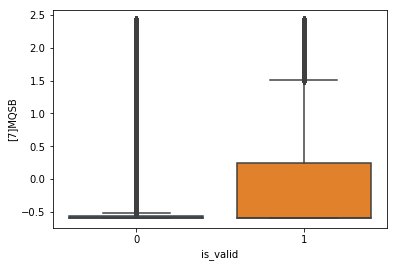

In [210]:
ax = sns.boxplot(x="is_valid", y="[7]MQSB", data=aDF_std)

* Mean for each category

In [211]:
aDF_std.groupby("is_valid").agg({'[7]MQSB': 'mean'})

,[7]MQSB
is_valid,
0,-0.265747
1,0.004358


* Median for each category

In [212]:
aDF_std.groupby("is_valid").agg({'[7]MQSB': 'median'})

,[7]MQSB
is_valid,
0,-0.590683
1,-0.590658


#### SGB-Segregation based metric

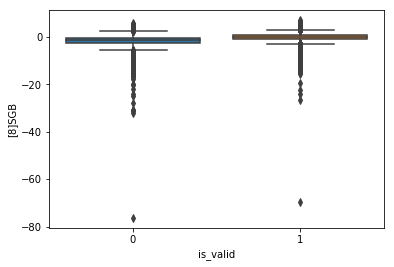

In [213]:
ax = sns.boxplot(x="is_valid", y="[8]SGB", data=aDF_std)

* Mean for each category

In [214]:
aDF_std.groupby("is_valid").agg({'[8]SGB': 'mean'})

,[8]SGB
is_valid,
0,-1.653139
1,0.027109


* Median for each category

In [215]:
aDF_std.groupby("is_valid").agg({'[8]SGB': 'median'})

,[8]SGB
is_valid,
0,-1.467237
1,0.083771


#### MQ0F-Fraction of MQ0 reads (smaller is better)

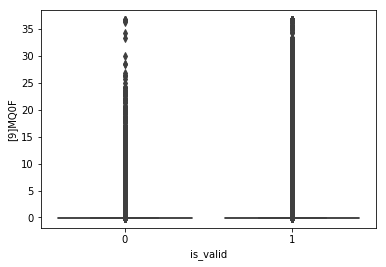

In [216]:
ax = sns.boxplot(x="is_valid", y="[9]MQ0F", data=aDF_std)

* Mean for each category

In [217]:
aDF_std.groupby("is_valid").agg({'[9]MQ0F': 'mean'})

,[9]MQ0F
is_valid,
0,0.068217
1,-0.001119


* Median for each category

In [218]:
aDF_std.groupby("is_valid").agg({'[9]MQ0F': 'median'})

,[9]MQ0F
is_valid,
0,-0.110868
1,-0.112802


#### ICB- Inbreeding Coefficient Binomial test (bigger is better)

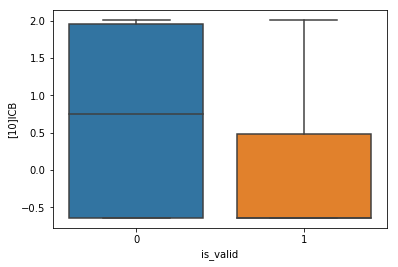

In [219]:
ax = sns.boxplot(x="is_valid", y="[10]ICB", data=aDF_std)

* Mean for each category

In [220]:
aDF_std.groupby("is_valid").agg({'[10]ICB': 'mean'})

,[10]ICB
is_valid,
0,0.662397
1,-0.010862


* Median for each category

In [221]:
aDF_std.groupby("is_valid").agg({'[10]ICB': 'median'})

,[10]ICB
is_valid,
0,0.746564
1,-0.640889


#### HOB - Bias in the number of HOMs number (smaller is better)

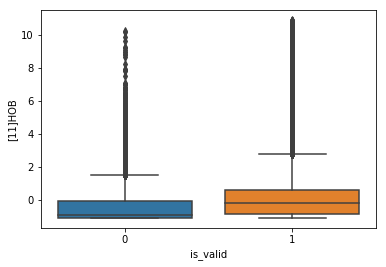

In [222]:
ax = sns.boxplot(x="is_valid", y="[11]HOB", data=aDF_std)

* Mean for each category

In [223]:
aDF_std.groupby("is_valid").agg({'[11]HOB': 'mean'})

,[11]HOB
is_valid,
0,-0.416712
1,0.006833


* Median for each category

In [224]:
aDF_std.groupby("is_valid").agg({'[11]HOB': 'median'})

,[11]HOB
is_valid,
0,-0.913804
1,-0.187012


#### MQ - Average mapping quality

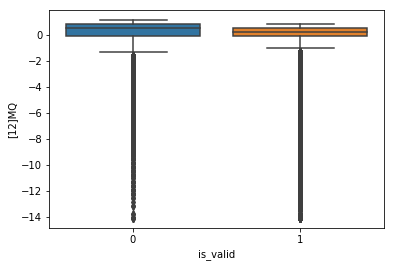

In [225]:
ax = sns.boxplot(x="is_valid", y="[12]MQ", data=aDF_std)

* Mean for each category

In [226]:
aDF_std.groupby("is_valid").agg({'[12]MQ': 'mean'})

,[12]MQ
is_valid,
0,0.142233
1,-0.002332


* Median for each category

In [227]:
aDF_std.groupby("is_valid").agg({'[12]MQ': 'median'})

,[12]MQ
is_valid,
0,0.490211
1,0.186954


### ML model

Let's the separate the predictors from the binary output

In [228]:
predictors=aDF_std[feature_names]

Now, let's create a dataframe with the outcome

In [229]:
outcome=aDF_std[['is_valid']]

Now, let's split the initial dataset into a training set that will be used to train the model and a test set, which will be used to test the performance of the fitted model

In [230]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.25, random_state=0)

By setting the `random_state` option, we ensure that the resuts are repeatable

Now, we use a Logistic Regression model to analyse our data:

In [231]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(verbose=1)

logisticRegr.fit(x_train, y_train)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

Now, we can check the accuracy of our fitted model by using the `x_test` and comparing with the true outcome in `y_test`

In [232]:
predictions = logisticRegr.predict(x_test)

We can also estimate the probability of each prediction:

In [233]:
predictions_probs = logisticRegr.predict_proba(x_test)

The returned probabilities are ordered by the label of classes, this can be checked by doing:

In [234]:
print(logisticRegr.classes_)

[0 1]


In [235]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.989471600971


Now, we can create a confusion matrix in order to assess the accuracy of our predictions:

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predictions)

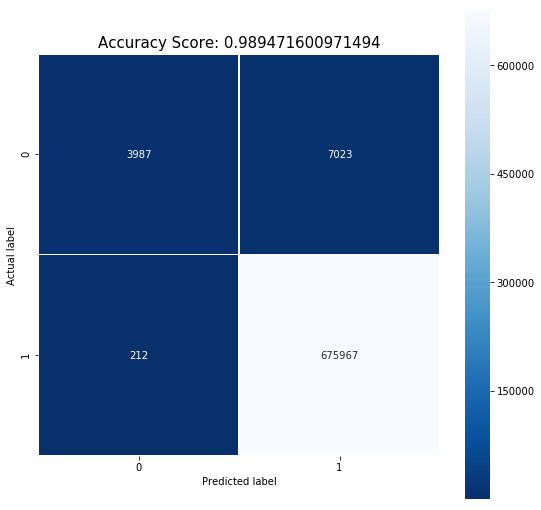

In [237]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

* Conclusion
It seems that this Logistic Regression classifier has a good performance (score=0.99)

### Model persistence
After checking that the model works, we can save it to a file so we can use it later. For this we will use `Pickle`:

In [238]:
import pickle

filename = 'finalized_model_snps.sav'
pickle.dump(logisticRegr, open(filename, 'wb'))

And later, we can reload the model from the file:

In [239]:
loaded_model = pickle.load(open(filename, 'rb'))

## INDELs
We are going to use two different INDELs VCFs, one has all the sites identified both by GIAB and us (`TP.highconf.vcf.gz`) and the other was identified by us and not by GIAB and are considered False Positive sites (`FP.highconf.vcf.gz`). Only the sites falling in the high-confidence regions as defined by GIAB are considered.
Then we extract the annotations for each of the files by doing:

Now, we read-in the annotations in each of the files into a Pandas dataframe

In [243]:
import pandas as pd
import numpy as np

%matplotlib inline

DF_TP=pd.read_csv('/Users/ernesto/SCRATCH/VARIANT_FILTERING/INDELS/TP_annotations.tsv',sep="\t",na_values=['.'])
DF_FP=pd.read_csv('/Users/ernesto/SCRATCH/VARIANT_FILTERING/INDELS/FP_annotations.tsv',sep="\t",na_values=['.'])

Now we will add a new column named `is_valid` to our two dataframes that will be 1 if the variant is real and will be 0 when the variant is a false positive. This new column will be the dependent binary variable in our classifier

In [244]:
DF_TP=DF_TP.assign(is_valid=1)
DF_FP=DF_FP.assign(is_valid=0)

And now we combine the two dataframes into a single dataframe:

In [245]:
frames = [DF_TP,DF_FP]
DF = pd.concat(frames)

Now, let's identify the columns with NA values:

In [246]:
DF.isna().any()

# [1]CHROM    False
[2]POS        False
[3]DP         False
[4]IDV        False
[5]IMF        False
[6]VDB        False
[7]SGB        False
[8]MQSB        True
[9]MQ0F       False
[10]ICB        True
[11]HOB        True
[12]MQ        False
is_valid      False
dtype: bool

We see several columns with NA values, and the question is how do we deal with them?
Well, there are 2 possibilities, to remove them by using the function `dropna()` or to impute them by using an estimator (mean, median). I will impute the missing values using the median calculated on each feature:

In [247]:
DF_num = DF.drop("# [1]CHROM", axis=1)

In [248]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
imputer.fit(DF_num)
X = imputer.transform(DF_num)

The Numpy array (X) is transformed back to a dataframe:

In [249]:
DF_tr = pd.DataFrame(X, columns=DF.columns.drop(['# [1]CHROM']))

### Normalization of the different features
Some of the machine learning algorithms require that the different predictors are in the same range and are comparable (i.e. having the same units). This is why it is better to do a previous step of data normalization (standardization), for this I am going to use `preprocessing` from `sklearn`

In [250]:
feature_names=DF_tr.columns.drop(['[2]POS','is_valid'])

In [251]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(DF_tr[feature_names])
std_array = std_scale.transform(DF_tr[feature_names])

`preprocessing` returns a NumPy array, so we need to transform to a Pandas data frame:

In [252]:
aDF_std=pd.DataFrame(data=std_array,columns=feature_names)

Now, let's add the column with the status of the variant( is_valid=0 or is_valid=1) to the normalized data frame

In [253]:
aDF_std.insert(loc=0, column='is_valid', value=DF_noNA['is_valid'].values)

ValueError: Length of values does not match length of index

### Initial exploration of the data
First, let's examine the number of records having `is_valid=1` (i.e. True positive) and `is_valid=0` (i.e. False Positive) 

In [ ]:
aDF_std.iloc[:,0].value_counts()

Let's examine the distribution of the different predictors depending on the `is_valid` variable.

#### DP (Raw read depth)

In [ ]:
import seaborn as sns
ax = sns.boxplot(x="is_valid", y="[3]DP", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[3]DP': 'mean'})

* Median for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[3]DP': 'median'})

Judging by the above boxplots and by the median and mean above, we can see that DP is bigger in real sites but that the false positive set present a higher number of DP outliers

#### IDV (Maximum number of reads supporting an indel)

In [ ]:
ax = sns.boxplot(x="is_valid", y="[4]IDV", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[4]IDV': 'mean'})

* Median for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[4]IDV': 'median'})

#### IMF (Maximum fraction of reads supporting an indel)

In [ ]:
ax = sns.boxplot(x="is_valid", y="[5]IMF", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[5]IMF': 'mean'})

* Median for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[5]IMF': 'median'})

#### VDB Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)

In [ ]:
ax = sns.boxplot(x="is_valid", y="[6]VDB", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[6]VDB': 'mean'})

* Median for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[6]VDB': 'median'})

#### MQSB-Mann-Whitney U test of Mapping Quality vs Strand Bias (bigger is better)

In [ ]:
ax = sns.boxplot(x="is_valid", y="[8]MQSB", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[8]MQSB': 'mean'})

* Median for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[8]MQSB': 'median'})

#### SGB-Segregation based metric

In [ ]:
ax = sns.boxplot(x="is_valid", y="[7]SGB", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[7]SGB': 'mean'})

* Median for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[7]SGB': 'median'})

#### MQ0F-Fraction of MQ0 reads (smaller is better)

In [ ]:
ax = sns.boxplot(x="is_valid", y="[9]MQ0F", data=aDF_std)

* Mean for each category

In [ ]:
aDF_std.groupby("is_valid").agg({'[9]MQ0F': 'mean'})

* Median for each category

In [254]:
aDF_std.groupby("is_valid").agg({'[9]MQ0F': 'median'})

KeyError: 'is_valid'

#### ICB- Inbreeding Coefficient Binomial test (bigger is better)

In [255]:
ax = sns.boxplot(x="is_valid", y="[10]ICB", data=aDF_std)

ValueError: Could not interpret input 'is_valid'

* Mean for each category

In [256]:
aDF_std.groupby("is_valid").agg({'[10]ICB': 'mean'})

KeyError: 'is_valid'

* Median for each category

In [257]:
aDF_std.groupby("is_valid").agg({'[10]ICB': 'median'})

KeyError: 'is_valid'

#### HOB - Bias in the number of HOMs number (smaller is better)

In [258]:
ax = sns.boxplot(x="is_valid", y="[11]HOB", data=aDF_std)

ValueError: Could not interpret input 'is_valid'

* Mean for each category

In [259]:
aDF_std.groupby("is_valid").agg({'[11]HOB': 'mean'})

KeyError: 'is_valid'

* Median for each category

In [260]:
aDF_std.groupby("is_valid").agg({'[11]HOB': 'median'})

KeyError: 'is_valid'

#### MQ - Average mapping quality

In [261]:
ax = sns.boxplot(x="is_valid", y="[12]MQ", data=aDF_std)

ValueError: Could not interpret input 'is_valid'

* Mean for each category

In [262]:
aDF_std.groupby("is_valid").agg({'[12]MQ': 'mean'})

KeyError: 'is_valid'

* Median for each category

In [263]:
aDF_std.groupby("is_valid").agg({'[12]MQ': 'median'})

KeyError: 'is_valid'

### ML model

Let's the separate the predictors from the binary output

In [264]:
predictors=aDF_std[feature_names]

Now, let's create a dataframe with the outcome

In [265]:
outcome=aDF_std[['is_valid']]

KeyError: "['is_valid'] not in index"

Now, let's split the initial dataset into a training set that will be used to train the model and a test set, which will be used to test the performance of the fitted model

In [266]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.25, random_state=0)

ValueError: Found input variables with inconsistent numbers of samples: [448791, 2748756]

By setting the `random_state` option, we ensure that the resuts are repeatable

Now, we use a Logistic Regression model to analyse our data:

In [267]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(verbose=1)

logisticRegr.fit(x_train, y_train)

# The estimated coefficients will all be around 1:
#print(logisticRegr.coef_)

print(np.std(x_train.values, 0)*logisticRegr.coef_)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear][[ 0.66190837  0.65074422 -0.05449061  0.23352117  0.04389624  1.58421511
  -0.40417832 -0.08368534  0.02926977 -1.20618591]]


Now, we can check the accuracy of our fitted model by using the `x_test` and comparing with the true outcome in `y_test`

In [268]:
predictions = logisticRegr.predict(x_test)

In [269]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.989471600971


Now, we can create a confusion matrix in order to assess the accuracy of our predictions:

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predictions)

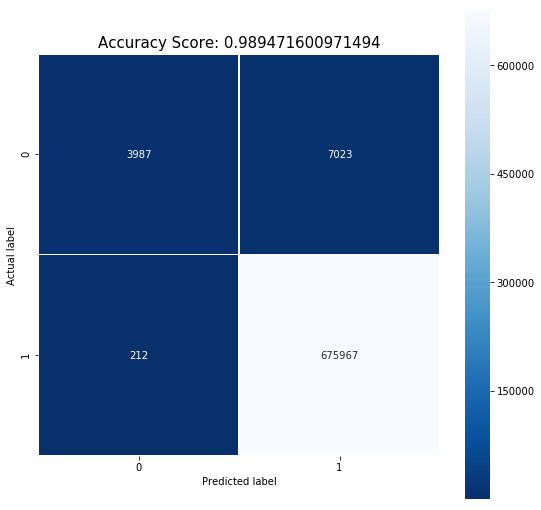

In [271]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

* Conclusion
It seems that this Logistic Regression classifier has a good performance (score=0.93)

### Model persistence
After checking that the model works, we can save it to a file so we can use it later. For this we will use `Pickle`:

In [272]:
import pickle

filename = 'finalized_model_indels.sav'
pickle.dump(logisticRegr, open(filename, 'wb'))

And later, we can reload the model from the file:

In [273]:
loaded_model = pickle.load(open(filename, 'rb'))